## Сколько нужно таксистов?

### Оглавление
[1. План проекта](#section1)\
[2. Знакомство с данными и их подготовка](#section2)\
[3. Обучение моделей и проверка на тестовой выборке](#section3)\
[4. Общий вывод](#section4)

<a id='section1'></a>
### 1.План проекта
- загрузим данные и выполним их ресемплирование по одному часу
- проанализируем данные
- обучим разные модели с различными гиперпараметрами
- проверим данные на тестовой выборке и сделаем выводы

<a id='section2'></a>
### 2. Знакомство с данными и их подготовка

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('F:/DS/Задачи Практикум/Projects/3 блок/Временные ряды/taxi.csv',
                 parse_dates = [0], index_col = [0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проверим, отстортированы ли даты.

In [4]:
df.index.is_monotonic

True

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Итак, у нас около 26 тыс. наблюдений с марта по август 2018 с интервалом в 10 минут. Семплируем ряд по часу.

In [6]:
df = df.resample('1H').sum()

Разделим выборку на:
   - тренировочную
   - тестовую
   
Не забывая, что при разбиении временных рядов данные тасовать нельзя.

In [7]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)

Проверим разбиение.

In [8]:
for i in [train, test]:
    print(i.index.min())
    print(i.index.max())

2018-03-01 00:00:00
2018-08-13 13:00:00
2018-08-13 14:00:00
2018-08-31 23:00:00


Отложим в сторону сформированный тест и поанализируем трейн.\
Посмотрим, как распределены значения ряда.

Text(0.5, 1.0, 'Распределение заказов такси')

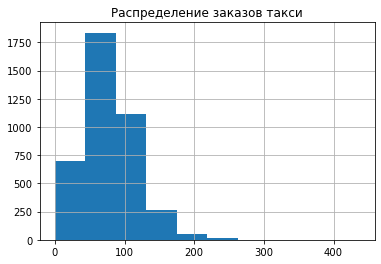

In [9]:
train.hist()
plt.title('Распределение заказов такси')

Text(0.5, 1.0, 'Распределение заказов такси')

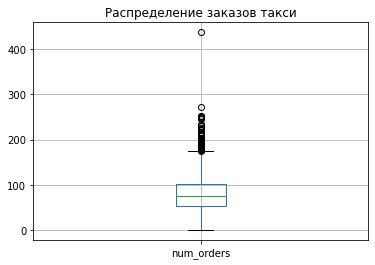

In [10]:
train.boxplot()
plt.title('Распределение заказов такси')

In [11]:
train.describe()

,num_orders
count,3974.000000
mean,78.290639
std,38.671812
min,0.000000
25%,52.000000
50%,75.000000
75%,101.000000
max,437.000000


Видим, что у распределения есть большой правый хвост, есть много крупных выбросов.

Посмотрим, как выглядит временной ряд.

Text(0.5, 1.0, 'Количество заказов такси')

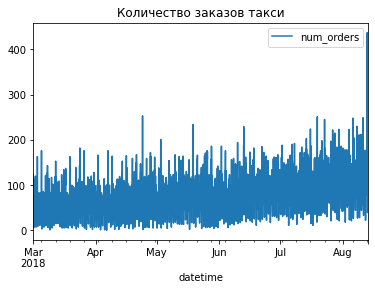

In [12]:
train.plot()
plt.title('Количество заказов такси')

Все смешалось. Декомпозируем временной ряд.

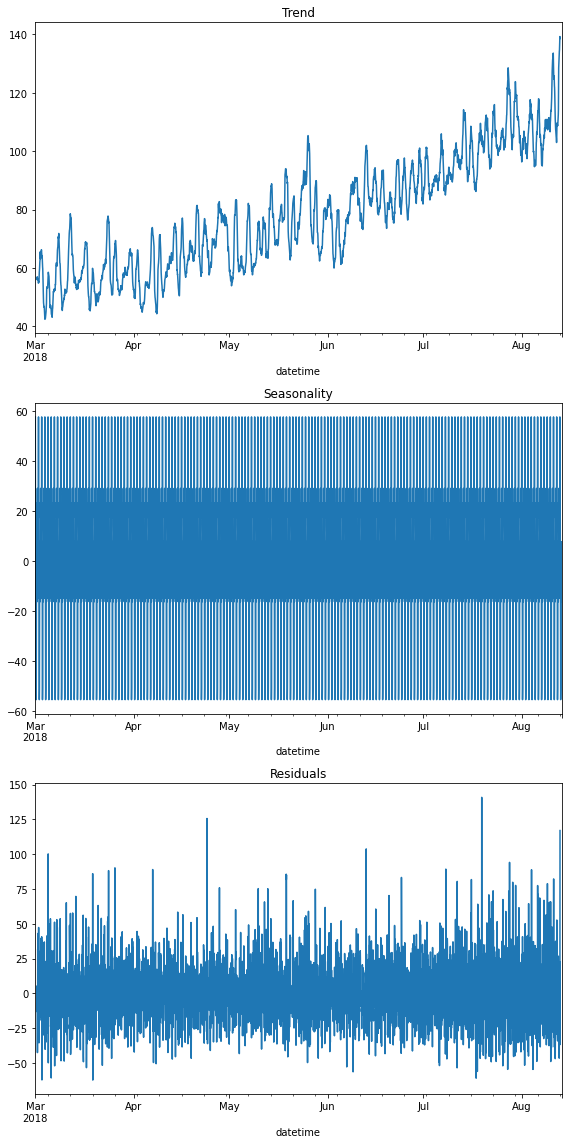

In [13]:
decomposed = seasonal_decompose(train['num_orders'])
plt.figure(figsize=(8, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим, что ряд:
- скорее всего, имеет тренд
- имеет сезонность в рамках месяца (мб зависимость от дня недели, часа, дня месяца)
- выбросы, которые мы обнаружили, являются шумом

Дополнительно изучим, какую сезонность имеем.

Text(0.5, 1.0, 'Сезонность 1 декады месяца')

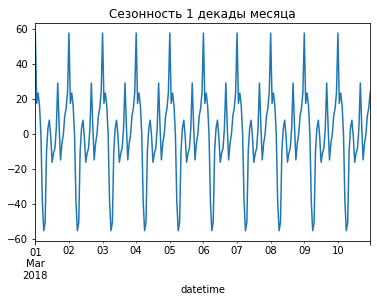

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-10'].plot()
plt.title('Сезонность 1 декады месяца')

Text(0.5, 1.0, 'Сезонность 2 декады месяца')

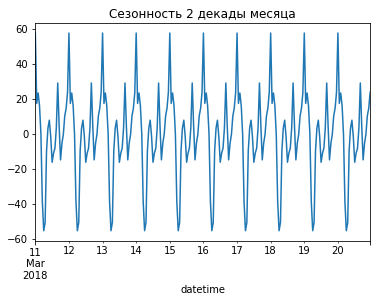

In [15]:
decomposed.seasonal['2018-03-11':'2018-03-20'].plot()
plt.title('Сезонность 2 декады месяца')

Text(0.5, 1.0, 'Сезонность 3 декады месяца')

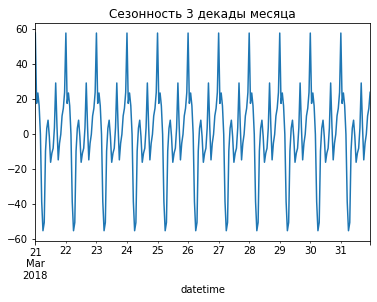

In [16]:
decomposed.seasonal['2018-03-21':'2018-03-31'].plot()
plt.title('Сезонность 3 декады месяца')

Видим, что скорее всего, сезонность у нас в пределах дня - часовая. Но для надежности создадим и иные календарные фичи, а потом проверим на features_importances, важны ли они.\
Создадим календарные фичи: день месяца, номер недели, день недели, час.

In [17]:
train_plus = train.copy()
train_plus['day'] = train_plus.index.day
train_plus['week'] = train_plus.index.week
train_plus['dayofweek'] = train_plus.index.dayofweek
train_plus['hour'] = train_plus.index.hour
for i in ['day', 'week', 'dayofweek', 'hour']:
    train_plus[i] = train_plus[i].astype('category')

Создадим также фичи типа "отстающие значения". Но для начала определим, какие лаги самые важные.\

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

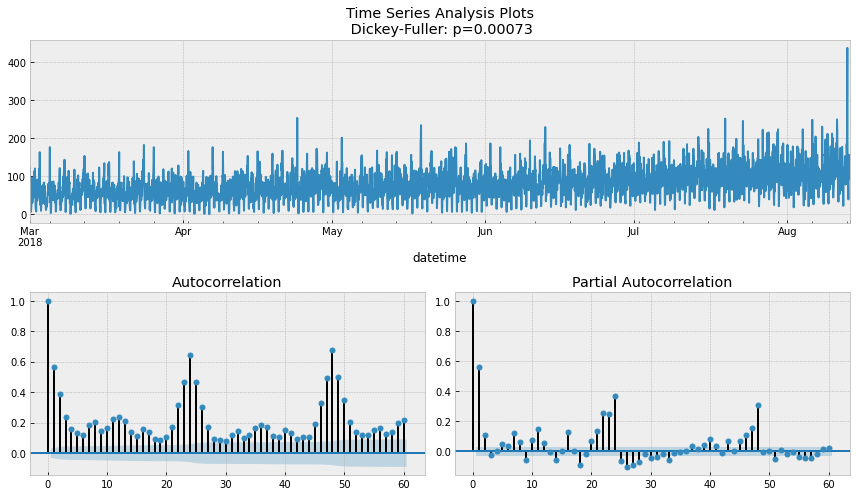

In [19]:
tsplot(train_plus['num_orders'], lags=60)

Мы имеем дело со стационарным рядом - коэффициент Дикки-Фулера близок к 0.
Ряд имеет сезонность, но мы смогли ее выделить автокорреляцией - видим, что сильные лаги кратны 24.\
Возьмем лаги до 25-ого. И окно для скользящей средней = 24.

In [20]:
for lag in range(1, 25):
    train_plus.loc[:, 'lag_{}'.format(lag)] = train_plus['num_orders'].shift(lag)

In [21]:
train_plus['mean'] = train_plus['num_orders'].shift(1).rolling(24).mean()

Удалим образовавшиеся наблюдения с NaN.

In [22]:
train_plus = train_plus.dropna()

Разделим тренировочную выборку на трейн и таргет.

In [23]:
features_train = train_plus.drop(['num_orders'], axis = 1)
target_train = train_plus['num_orders']

Сделаем OHE и масштабируем признаки.

In [24]:
enc = OneHotEncoder(handle_unknown = 'ignore')
features_train_OHE = enc.fit_transform(features_train)
features_train_OHE = features_train_OHE.toarray()
scaler = StandardScaler()
scaler.fit(features_train_OHE)
features_train_scaled = scaler.transform(features_train_OHE)

<a id='section3'></a>
### 3. Обучение моделей и проверка на тестовой выборке

Подготовим тестовую выборку - обработаем ее также, как тренировочную.\
Учтем, что при формировании лагов появляются NaN, поэтому приклеим к тесту нижнюю часть трейна, сформируем лаги, а потом удалим строки с NaN.

In [25]:
test = pd.concat([train['2018-08-12 14:00:00':'2018-08-13 13:00:00'], test], axis = 0)

In [26]:
def features_transform(df):
    df['day'] = df.index.day
    df['week'] = df.index.week
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for i in ['day', 'week', 'dayofweek', 'hour']:
        df[i] = df[i].astype('category')
    for lag in range(1, 25):
        df.loc[:, 'lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['mean'] = df['num_orders'].shift(1).rolling(24).mean()
    df = df.dropna()
    features = df.drop(['num_orders'], axis = 1)
    target = df['num_orders']
    features_OHE = enc.transform(features)
    features_OHE = features_OHE.toarray()
    features_scaled = scaler.transform(features_OHE)
    
    return features, features_OHE, features_scaled, target

In [27]:
FEAT = features_transform(test)
features_test = FEAT[0]
features_test_OHE = FEAT[1]
features_test_scaled = FEAT[2]
target_test = FEAT[3]

#### Константная модель

Создадим контантную модель, чтобы проверять другие на адекватность.\
Таргеты теста предскажем средним ряда, так как скор-метрика у нас RMSE.\
И посчитаем RMSE.

In [28]:
predictions_const = pd.Series(target_train.mean(), index = target_test.index)
print('RMSE константной модели:', int(mean_squared_error(target_test, predictions_const)**(1/2)))

RMSE константной модели: 84


#### Линейная регрессия

In [29]:
model_LR = LinearRegression()
model_LR.fit(features_train_scaled, target_train)
predictions_LR = model_LR.predict(features_test_scaled)
print('RMSE линейной регрессии:', int(mean_squared_error(target_test, predictions_LR)**(1/2)))

RMSE линейной регрессии: 72


#### CatBoost

In [30]:
model_cat = CatBoostRegressor(loss_function = 'RMSE', cat_features = [0,1,2,3], verbose=100, learning_rate = 0.4)
model_cat.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_test)

0:	learn: 32.7834685	total: 180ms	remaining: 2m 59s
100:	learn: 14.0295927	total: 2.46s	remaining: 21.9s
200:	learn: 10.2826283	total: 4.74s	remaining: 18.8s
300:	learn: 7.6679506	total: 7.13s	remaining: 16.6s
400:	learn: 6.0732490	total: 9.44s	remaining: 14.1s
500:	learn: 4.7602635	total: 11.8s	remaining: 11.7s
600:	learn: 3.7704845	total: 14.1s	remaining: 9.35s
700:	learn: 3.1030370	total: 16.4s	remaining: 7.01s
800:	learn: 2.5480951	total: 18.7s	remaining: 4.64s
900:	learn: 2.1104076	total: 21s	remaining: 2.31s
999:	learn: 1.7610539	total: 23.4s	remaining: 0us


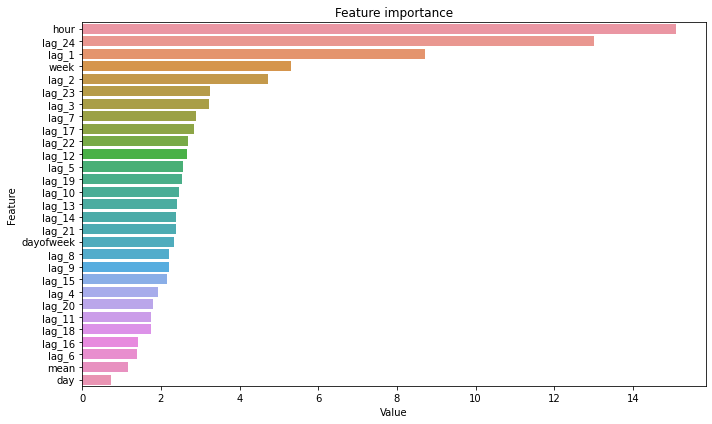

In [31]:
feature_importance = model_cat.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
plt.figure(figsize = (10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show()

Занятно - CatBoost выделяет еще недельную сезонность, хотя метод seasonal_decompose ее не выявил.

In [32]:
print('RMSE Catboost:', int(mean_squared_error(target_test, predictions_cat)**(1/2)))

RMSE Catboost: 41


#### XGBRegressor

In [33]:
model_xgb = XGBRegressor(eval_metric = 'rmse')
param_search = {'eta': [0.1, 0.5],
               'gamma': [0, 5],
               'max_depth' : [3, 10],
               'alpha': [0, 0.9]}
tscv = TimeSeriesSplit(n_splits = 5)
gsearch = GridSearchCV(estimator=model_xgb, cv=tscv,
                        param_grid=param_search)
gsearch.fit(features_train_OHE, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='rmse',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                

In [34]:
predictions_xgb = gsearch.predict(features_test_OHE)
print('RMSE XGBoost:', int(mean_squared_error(target_test, predictions_xgb)**(1/2)))

RMSE XGBoost: 71


<a id='section4'></a>
### 4. Общий вывод

Чтобы понять спрос на такси по часам, мы решали задачу прогнозирования временного ряда.\
Выявили, что ряд имеет сезонность - т.е. зависимость спроса от часа дня и от номера недели в месяце.\
Также ряд имеет растущий тренд. Поэтому не использовали случайный лес, так как он плохо прогнозирует тренд.\
Для прогноза мы создавали фичи, т.е. делали feature ingineering. Из них выбирали самые значимые.\
Спрогнозировали спрос с помощью разных моледей машинного обучения.\
При подборе гиперпараметров модели с помощью кросс-валидации учли, что при разбиении датасета на части, их нельзя перемешивать, как при обычной кросс-валидации.

Получили вот такие значения скора:
 - Константная модель: RMSE = 84
 - Линейная регрессия: RMSE = 72
 - CatBoost: RMSE = 41
 - XGBRegressor = 71
 
 Лучшее качество при прогнозировании данного ряда дал CatBoost. Предлоджим заказчику использовать данную модель.

Text(0.5, 1.0, 'Сравнение лучшего прогноза (темный) и истинных значений (светлый)')

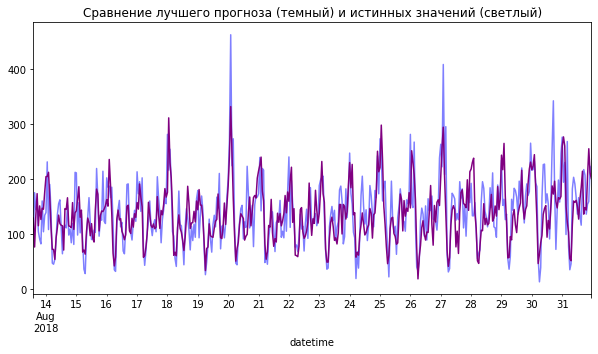

In [35]:
plt.figure(figsize = (10, 5))
ax = target_test.plot(color = 'blue', alpha = 0.5)
pd.Series(predictions_cat, index = list(target_test.index)).plot(ax = ax, color = 'purple')
plt.title('Сравнение лучшего прогноза (темный) и истинных значений (светлый)')